In [1]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss

# Run specific
DATASET = "fashion-mnist" # "mnist", "fashion-mnist", "cifar"
EPOCHS = 15
QUBITS = 4
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
LOSS_FUNC = NLLLoss()
PERTURB = False
RESUME_TRAINING = True
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
RUN = "2"
# Constants
QC_REPETITIONS = 1
CLASSES = 4
BATCH_SIZE = 256
FEATURE_BRIGHTNESS = 2
FEATURE_ANGLES = 2
FEATURE_FREQUENCIES = 1

#For dynamic kernels
KERNEL="dynamic"
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2

#Derived:
TOTAL_FEATURES_PER_SITE = FEATURE_BRIGHTNESS + FEATURE_ANGLES * FEATURE_FREQUENCIES * 2
TOTAL_FEATURES = SIMPLE_NEURONS_PER_FEATURE_PER_ROW * SIMPLE_NEURONS_PER_FEATURE_PER_ROW * TOTAL_FEATURES_PER_SITE

FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-q{QUBITS}-{QC_REPETITIONS}-c{CLASSES}-n{TOTAL_FEATURES}-k{KERNEL}'
COMMON_FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-n{TOTAL_FEATURES}-k{KERNEL}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])


## Settings
DEBUG = False
SAMPLE_RUN = False
SAMPLE_ITERATIONS = 10


In [2]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAt
from canonicallayers.gaborfilterextractor import extract_power_feats
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform
algorithm_globals.random_seed = 42

In [3]:
# Step 3: Prepare Training data
# -------------

train_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-training.pt')
test_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-testing.pt')


images shape torch.Size([256, 1, 28, 28])


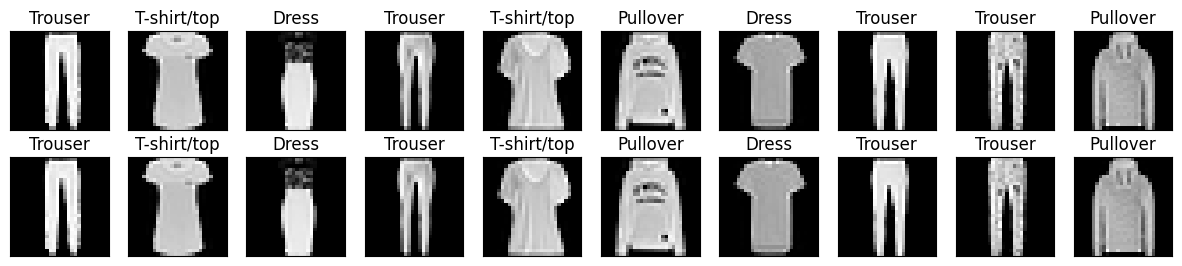

In [4]:
# Step 4 - Visualize dataset

n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show > 0:
    originalImage = images[n_samples_show,0]
      
    if(PERTURB):
      perturbation = "none"
      match random.randint(0, 3):
          case 0:
            perturbedImage = skew(originalImage.numpy())
            perturbation = "skew"
          case 1:
            angle = 3*np.random.random()/5
            perturbedImage = rotate(originalImage.numpy(), angle)
            perturbation = f"rotate {np.round(angle*180/np.pi)}°"
          case 2:
            perturbedImage = noise(originalImage.numpy())
            perturbation = "noise"
          case _:
            perturbedImage = elastic_transform(originalImage.numpy())
            perturbation = "elastic"
      perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show - 1].set_xticks([])
    axes[0,n_samples_show - 1].set_yticks([])
    axes[0,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show - 1].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title("{}".format(perturbation))
    else:
      axes[1,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
      
    n_samples_show -= 1

In [5]:
# Step 6 - Setup Feature Extraction parameters

gaborReceptiveFields = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborReceptiveFields.pt")
gaborKernels = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborKernels.pt")
gaborAngleTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborAngleTunings.pt")
gaborFrequencyTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborFrequencyTunings.pt")


In [6]:
# Step 7- Define QNN Model

def parity(x):
    return x % CLASSES

# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(QUBITS, reps=QC_REPETITIONS)
    ansatz = RealAmplitudes(QUBITS, reps=1)
    qc = QuantumCircuit(QUBITS)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=parity,
        output_shape=CLASSES
    )
    return qnn


qnn4 = create_qnn()

In [7]:
# Step 8 - Feature extraction functions
dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
gaborImgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1 # IMAGE_WIDTH - MIN_KERNEL_SIZE_GABOR +1


def extractFeatures(data, brightnessReceptiveFields, brightnessTunings, brightnessKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels):
  f = torch.zeros(data.shape[0],TOTAL_FEATURES_PER_SITE,SIMPLE_NEURONS_PER_FEATURE_PER_ROW,SIMPLE_NEURONS_PER_FEATURE_PER_ROW)
  # print("f", f.shape)
  #Fill Brigtness, orientation input
  for bi in range(0, data.shape[0]):
    for i in range(0, SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
      for j in range(0,SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
        featureIndex = 0
        brightnessSpot = brightnessReceptiveFields[i][j]
        brightnessKernelSize = brightnessKernels[i][j]

        for br in range(0, FEATURE_BRIGHTNESS):
          brightnessTuning = brightnessTunings[br][i][j]
          b = extractBrightnessAt(data[bi].unsqueeze(0), brightnessTuning, brightnessSpot//imgWidth, brightnessSpot%imgWidth, brightnessKernelSize)
          f[bi][featureIndex][i][j] = b
          featureIndex += 1
        
        gaborSpot = gaborReceptiveFields[i][j].item()
        gaborKernelSize = gaborKernels[i][j].item()

        for an in range(0, FEATURE_ANGLES):
          for fr in range(0, FEATURE_FREQUENCIES):
            gaborFrequency = gaborFrequencyTunings[fr][i][j].item()
            gaborAngle = gaborAngleTunings[an][i][j].item()
            kernel, power_feats, power_img = extract_power_feats(data[bi].unsqueeze(0), gaborKernelSize, gaborSpot//gaborImgWidth, gaborSpot%gaborImgWidth, gaborFrequency, gaborAngle)
            f[bi][featureIndex][i][j] = power_feats[0]
            f[bi][featureIndex+1][i][j] = power_feats[1]
            featureIndex += 2
  return f

In [8]:
# Step 9 - Define torch NN module
class Net(Module):
    def __init__(self, qnn):
      super().__init__()
      self.fc1 = Linear(TOTAL_FEATURES, 32 * QUBITS)
      self.relu1 = ReLU()
      self.fc2 = Linear(32 * QUBITS, QUBITS)  # QUBIT-dimensional input to QNN
      self.relu2 = ReLU()
      self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen

    def forward(self, x):
      if(DEBUG):
        print("x shape", x.shape)
      x = extractFeatures(x, gaborReceptiveFields, gaborBrightnessTunings, gaborKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels)
      if(DEBUG):
        print("x features shape", x.shape)
      x = x.view(x.shape[0], -1)
      if(DEBUG):
        print("x after flat", x.shape)
      x = self.fc1(x)
      x = self.relu1(x)
      if(DEBUG):
        print("X after fc1", x.shape)
      x = self.fc2(x)
      x = self.relu2(x)
      if(DEBUG):
        print("x after fc2", x.shape)
      x = self.qnn(x)  # apply QNN
      if(DEBUG):
        print("After qnn, output", x.shape, x)
      return x




In [9]:
# Step 10 - Define torch NN module for Cifar

class CifarNet(Module):
    def __init__(self, qnn):
      super().__init__()
      self.conv1 = Conv2d(1, 32, kernel_size=3, padding=1)
      self.relu1 = ReLU()
      self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
      self.mp2 = MaxPool2d(2, 2) # output: 64 x 16 x 16

      self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
      self.relu3 = ReLU()
      self.conv4 = Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
      self.mp4 = MaxPool2d(2, 2) # output: 128 x 8 x 8

      self.conv5 = Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
      self.relu5 = ReLU()
      self.conv6 = Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
      self.mp6 = MaxPool2d(2, 2) # output: 256 x 4 x 4
      self.flatten = Flatten()
      self.fc1 = Linear(1024*4*4, 1024)
      self.relu7 = ReLU()
      self.fc2 = Linear(1024, 512)
      self.relu8 = ReLU()
      self.fc3 = Linear(512, QUBITS)
      self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen

    def forward(self, x):
      if(DEBUG):
        print("x shape", x.shape)
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.mp2(x)

      x = self.conv3(x)
      x = self.relu3(x)
      x = self.conv4(x)
      x = self.mp4(x)

      x = self.conv5(x)
      x = self.relu5(x)
      x = self.conv6(x)
      x = self.mp6(x)

      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu7(x)
      x = self.fc2(x)
      x = self.relu8(x)
      x = self.fc3(x)
      x = self.qnn(x)  # apply QNN
      return x


In [10]:
# Step 11 - Initialize model

if DATASET == "blahblahblah":
  model = CifarNet(qnn4)
else:
  model = Net(qnn4)

In [11]:
# Step 12 - Load previous results

loss_list = []  # Store loss history
training_stats = [0, 0.0, 0] #Epochs, Accuracy, Training Time
resume_stats = [-1, -1]
if(RESUME_TRAINING and (path.isfile(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))):
  model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))
  loss_list = torch.load(f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
if(path.isfile(f'checkpoints/{FILENAME_PREFIX}-trainingstats.pt')):
  training_stats = torch.load(f"checkpoints/{FILENAME_PREFIX}-trainingstats.pt")
if(path.isfile(f'checkpoints/{FILENAME_PREFIX}-trainresumestats.pt')):
  resume_stats = torch.load(f"checkpoints/{FILENAME_PREFIX}-trainresumestats.pt")

  

Completed Epochs 0 Accuracy 0.0


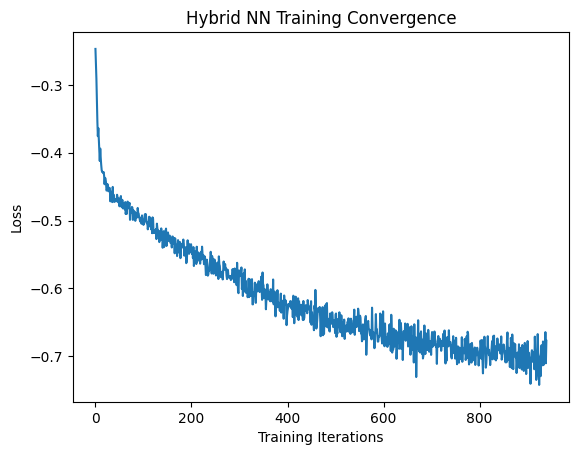

In [12]:
# Step 13 - Plot Prior Losses
print("Completed Epochs", training_stats[0], "Accuracy", training_stats[1])
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

In [13]:
gaborReceptiveFields = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborReceptiveFields.pt")
gaborKernels = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborKernels.pt")
gaborAngleTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborAngleTunings.pt")
gaborFrequencyTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborFrequencyTunings.pt")
gaborBrightnessTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborBrightnessTunings.pt")

In [14]:
# Step 14 - Extact features

# Define model, optimizer, and loss function
start_time = datetime.now()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = LOSS_FUNC

# Start training
epochs = EPOCHS  # Set number of epochs
model.train()  # Set model to training mode
# m = Softmax(dim=3)

print(DATASET, QUBITS, "Qubits, ", training_stats[0], "prior epochs, ", "Accuracy", '{0:.1f}%'.format(training_stats[1]), "Training Set:", len(train_loader.dataset), "Epochs", EPOCHS, "Batch Size:", BATCH_SIZE, "Number of batches:", (len(train_loader.dataset)//BATCH_SIZE)+1)
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        if(resume_stats[0] > epoch or (resume_stats[0] == epoch and resume_stats[1] >= batch_idx)):
          print(epoch, batch_idx, "already processed")
          continue
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        if(DEBUG):
          print("epoch", epoch, "batch", batch_idx)
        # print("indexes", batch_idx*BATCH_SIZE, batch_idx*BATCH_SIZE+BATCH_SIZE)
        # features = train_features[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE, :, :, :]
        # print("features", features[0, :, 0, 0])
        # print("x", x[0, :, 0, 0])
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(epoch, batch_idx, "Loss", loss.item(), end="")
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        loss_list.append(loss.item())
        resume_stats[0] = epoch
        resume_stats[1] = batch_idx
        torch.save(loss_list, f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
        torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-modelweights.pt')
        torch.save(resume_stats, f"checkpoints/{FILENAME_PREFIX}-trainresumestats.pt")
        print(".")
        if(SAMPLE_RUN == True and batch_idx >= SAMPLE_ITERATIONS):
          break
    end_time = datetime.now()
    elapsed = end_time - start_time
    training_stats[0] = training_stats[0] + 1
    if(len(training_stats)<3):
      training_stats.append(0)
    training_stats[2] = training_stats[2] + elapsed.total_seconds()
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]), "Elapsed", elapsed.total_seconds(), "total elapsed", training_stats[2])

    torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-modelweights-{epoch}.pt')


fashion-mnist 4 Qubits,  0 prior epochs,  Accuracy 0.0% Training Set: 24000 Epochs 15 Batch Size: 256 Number of batches: 94
0 0 already processed
0 1 already processed
0 2 already processed
0 3 already processed
0 4 already processed
0 5 already processed
0 6 already processed
0 7 already processed
0 8 already processed
0 9 already processed
0 10 already processed
0 11 already processed
0 12 already processed
0 13 already processed
0 14 already processed
0 15 already processed
0 16 already processed
0 17 already processed
0 18 already processed
0 19 already processed
0 20 already processed
0 21 already processed
0 22 already processed
0 23 already processed
0 24 already processed
0 25 already processed
0 26 already processed
0 27 already processed
0 28 already processed
0 29 already processed
0 30 already processed
0 31 already processed
0 32 already processed
0 33 already processed
0 34 already processed
0 35 already processed
0 36 already processed
0 37 already processed
0 38 already

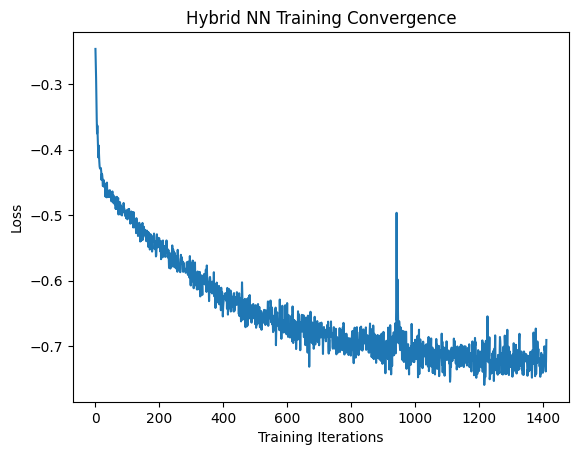

In [15]:
# Step 15 - Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Step 16 - Load model for evaluation

qnn = create_qnn()
if DATASET == "blahblahblah":
  model = CifarNet(qnn4)
else:
  model = Net(qnn4)
model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))

In [ ]:
# Step 17 - Plot feature extraction kernels

def plotKernel(ax, locations, kernels, tunings, title):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
  ax.plot([0, 0],[IMAGE_WIDTH, IMAGE_WIDTH])
  cycol = cycle('bgrcmk')
  Y = []
  X = []
  C=[]
  S=[]
  kernelSize=[]
  tuningX=[]
  tuningY=[]
  tuningValue=[]
  for iy, ix in np.ndindex(locations.shape):
    y = locations[iy, ix] // imgWidth
    x = locations[iy, ix] % imgWidth
    Y.append(y)
    X.append(x)
    ks = kernels[iy, ix].item()
    kernelSize.append(ks * ks * 2000/(IMAGE_WIDTH*IMAGE_WIDTH))
    tuningX.append(x + ks/2)
    tuningY.append(y + ks/2)
    size = kernels[iy, ix].item()
    S.append(size)
    tuningValue.append(tunings[iy, ix].item())
    ax.add_patch(Rectangle((x.item(), y.item()), size, size, facecolor= 'none', edgecolor=next(cycol), alpha=0.75))
  ax.scatter(tuningX, tuningY,c=tuningValue, s=kernelSize, cmap='Greys', alpha=0.75)
    # print(x.item(), y.item(), kernels[iy, ix].item())



In [ ]:
# Step 18 - Predict

model.eval()  # set model to evaluation mode
with no_grad():
  dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1

  correct = 0
  total = 0
  print("Testing Set size:", len(test_loader.dataset), "Batch Size:", BATCH_SIZE, "Number of batches:", (len(test_loader.dataset)//BATCH_SIZE)+1)

  for batch_idx, (data, target) in enumerate(test_loader):
    # if(batch_idx == 12):
    #   break
    features = test_features[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE, :, :, :]
    if(features.shape[0] == 0):
      break
    output = model(features)
    # print("prediction output", output)
    print(total, end=" ")
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)
    total += pred.shape[0]
    correct += pred.eq(target.view_as(pred)).sum().item()

    loss = loss_func(output, target)
    total_loss.append(loss.item())

  print(
      "Performance on test data:\n\tLoss: {:.4f}\n\tDataset: {}, Classes: {}, Features: {}, Qubits: {}, Epochs: {} New Epochs: {}\n\tAccuracy: {:.1f}% to {:.1f}%".format(
          sum(total_loss) / len(total_loss), DATASET,
          CLASSES, TOTAL_FEATURES, QUBITS, training_stats[0], EPOCHS,
          training_stats[1], correct * 100 / total
      )
  )
  training_stats[1] = correct * 100 / total

  torch.save(training_stats, f"checkpoints/{FILENAME_PREFIX}-trainingstats.pt")


In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table